In [334]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pylab as pl
import pandas as pd
import os
from IPython.core.display import HTML

import matplotlib.mlab as mlab
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
#from plotly.graph_objs import Scatter, Figure, Layout
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)



In [335]:
x = pd.read_excel("zap_resultado1400_2017-05-29.xlsx")

In [336]:
x.head(5)

,link,preco,bairro,endereco,quartos,area,suites,vagas,descricao
1,https://www.zapimoveis.com.br/lancamento/apartamento+venda+botafogo+zona-sul+rio-de-janeiro+rj+you-botafogo+ultima-chamada+66m2-97m2/ID-11765/?contato=0,Sob consulta,Botafogo,Rua Real Grandeza •\r\n Rio de Janeiro\r\n RJ,2 a 3 quartos,66 a 97m2,1 suíte,1 a 2 vagas,"Apartamento na Planta\r\n Sofisticação e design em Botafogo. O You Botafogo traz tudo o que você e sua família procuram. Ampla área de lazer, localização\nprivilegiada..."
2,https://www.zapimoveis.com.br/lancamento/apartamento+venda+botafogo+zona-sul+rio-de-janeiro+rj+sorocaba-112+julio-bogoricin+93m2-110m2/ID-12943/?contato=0,R$ 1.380.000,Botafogo,Rua Sorocaba •\r\n Rio de Janeiro\r\n RJ,2 a 3 quartos,93 a 110m2,1 suíte,1 a 2 vagas,Apartamento Pronto Para Morar\r\n O Sorocaba 112 é um empreendimento limitado (em termos de unidades) e quase infinito pelo o conforto.
3,https://www.zapimoveis.com.br/lancamento/apartamento+venda+botafogo+zona-sul+rio-de-janeiro+rj+pinheiro-guimaraes-75+julio-bogoricin+105m2-131m2/ID-12938/?contato=0,R$ 1.380.000,Botafogo,Rua Pinheiro Guimarães •\r\n Rio de Janeiro\r\n RJ,2 a 4 quartos,105 a 131m2,1 a 2 suítes,1 a 3 vagas,"Apartamento Pronto Para Morar\r\n Apartamentos de 2, 3 e 4 quartos, com opção de plantas customizadas, lazer completo e até 3 vagas na garagem além de muita, muita sofisticaç..."
4,https://www.zapimoveis.com.br/superdestaque/venda+apartamento+2-quartos+copacabana+zona-sul+rio-de-janeiro+rj+85m2+RS1350000/ID-13800514/,R$ 1.350.000,Copacabana,Rua Marechal Mascarenhas de Morais •\r\n Rio de Janeiro\r\n RJ,2 quartos,85m2,1 suíte,2 vagas,"Apartamento\r\n Prédio excelente, portaria luxuosa com entrada também pela Rua Conrado Niemeyer, porteiro 24 horas, prédio apenas 16 anos de construção, pis..."
5,https://www.zapimoveis.com.br/superdestaque/venda+apartamento+3-quartos+leblon+zona-sul+rio-de-janeiro+rj+125m2+RS3500000/ID-11602082/,R$ 3.500.000,Leblon,Rua General Venâncio Flores •\r\n Rio de Janeiro\r\n RJ,3 quartos,125m2,1 suíte,1 vaga,"Apartamento\r\n Alto padrão, totalmente reformado, iluminado e decorado por arquiteto renomado. More com charme nesta rua nobre e tranquila no coração do Le..."


In [337]:
# Vamos ver quantos tem vaga e quantos tem suites e quartos
df = x.copy()
("Numero de apts que possuem valores não nulos pra cada coluna")
df.count()

link         35000
preco        35000
bairro       35000
endereco     35000
quartos      33600
area         35000
suites       14788
vagas        15368
descricao    35000
dtype: int64

In [338]:
#Substituo os NaN nas suites e vagas por "0"

df.suites = df.suites.fillna("0")
df.vagas = df.vagas.fillna("0")

#Tiro os apts que não tem quartos (podem ser apenas vagas sendo vendidas, em vez de apartamentos inteiros)

df = df.dropna(subset=["quartos"]) 

#Eliminar o "m2" do final do valor das areas

df['area'] = df['area'].map(lambda x: x.replace("m2",""))

#Eliminar o "vagas" ao final das vagas


df.vagas = df.vagas.str.rstrip("vagas")

# Tiro as entradas que tem preço "Sob consulta"

df = df[df.preco.str.contains("Sob consulta") == False]

# Tirar "R$" da frente do valor do preço e os pontos e transformar coluna para inteiro

df['preco'] = df['preco'].replace('[\R$]','',regex=True)
df['preco'] = df['preco'].replace('[\.]','',regex=True).astype(float)

df.quartos.value_counts()

1 quarto         12840
2 quartos        9598 
3 quartos        6828 
4 quartos        707  
2 a 3 quartos    600  
2 a 4 quartos    589  
5 quartos        28   
Name: quartos, dtype: int64

In [339]:
#Tomar apenas o primeiro valor dos quartos, já que sempre o anunciado para mais de um apt é "A partir de X reais"
#Supõe-se que o preço do imóvel divulgado é para o valor mínimo de quartos anunciado. O mesmo pra suítes, vagas e área.

df["quartos"] = df["quartos"].map((lambda x: x[0])).astype(int)
df["suites"] = df["suites"].map((lambda x: x[0])).astype(int)
df["vagas"] = df["vagas"].map((lambda x: x[0])).astype(int)
df["area"] = df["area"].map((lambda x: x.split(' ', 1)[0])).astype(int)

# Tomar endereco apenas como o nome da rua
df["endereco"] = df["endereco"].map(lambda x: x.split('•', 1)[0].rstrip().lstrip()) # split() only once

#Defino uma nova coluna chamada "preço_m2", que será o preço/metro quadrado
df["preco_m2"] = df.preco/df.area

df.quartos.value_counts()

1    12840
2    10787
3    6828 
4    707  
5    28   
Name: quartos, dtype: int64

In [340]:
df = df.reset_index()
df.to_excel("zap_resultado_limpo.xlsx")

In [341]:
data = pd.read_excel("zap_resultado_limpo.xlsx")

- Quais as principais diferenças entre os apartamentos de cada bairro da Zona Sul do Rio de Janeiro?
- Quais os bairros com os aluguéis mais caros?
- Quantos quartos os apartamentos têm em média?
- A oferta de apartamentos de um bairro influencia o preço médio do aluguel?


# Análise Geral

## Valor de venda

Qual o valor de 1 vaga? e 1 quarto?
Qual o bairro com melhor média Preço/m2?

In [342]:
azul = "#01a2d9" # definir cor para usar nos gráficos


,index,link,preco,bairro,endereco,quartos,area,suites,vagas,descricao,preco_m2
0,2,https://www.zapimoveis.com.br/lancamento/apartamento+venda+botafogo+zona-sul+rio-de-janeiro+rj+sorocaba-112+julio-bogoricin+93m2-110m2/ID-12943/?contato=0,1380000,Botafogo,Rua Sorocaba,2,93,1,1,Apartamento Pronto Para Morar\r\n O Sorocaba 112 é um empreendimento limitado (em termos de unidades) e quase infinito pelo o conforto.,14838.709677
1,3,https://www.zapimoveis.com.br/lancamento/apartamento+venda+botafogo+zona-sul+rio-de-janeiro+rj+pinheiro-guimaraes-75+julio-bogoricin+105m2-131m2/ID-12938/?contato=0,1380000,Botafogo,Rua Pinheiro Guimarães,2,105,1,1,"Apartamento Pronto Para Morar\r\n Apartamentos de 2, 3 e 4 quartos, com opção de plantas customizadas, lazer completo e até 3 vagas na garagem além de muita, muita sofisticaç...",13142.857143
2,4,https://www.zapimoveis.com.br/superdestaque/venda+apartamento+2-quartos+copacabana+zona-sul+rio-de-janeiro+rj+85m2+RS1350000/ID-13800514/,1350000,Copacabana,Rua Marechal Mascarenhas de Morais,2,85,1,2,"Apartamento\r\n Prédio excelente, portaria luxuosa com entrada também pela Rua Conrado Niemeyer, porteiro 24 horas, prédio apenas 16 anos de construção, pis...",15882.352941
3,5,https://www.zapimoveis.com.br/superdestaque/venda+apartamento+3-quartos+leblon+zona-sul+rio-de-janeiro+rj+125m2+RS3500000/ID-11602082/,3500000,Leblon,Rua General Venâncio Flores,3,125,1,1,"Apartamento\r\n Alto padrão, totalmente reformado, iluminado e decorado por arquiteto renomado. More com charme nesta rua nobre e tranquila no coração do Le...",28000.000000
4,6,https://www.zapimoveis.com.br/superdestaque/venda+apartamento+2-quartos+leblon+zona-sul+rio-de-janeiro+rj+206m2+RS2900000/ID-13360654/,2900000,Leblon,Rua Sambaíba,2,206,0,2,"Apartamento\r\n Apartamento triplex mais terraço, com área total de 206m² com elevador interno, no bloco de fundos. 1º piso: Sala, lavabo, cozinha, área de ...",14077.669903
5,7,https://www.zapimoveis.com.br/oferta/venda+apartamento+1-quarto+copacabana+zona-sul+rio-de-janeiro+rj+54m2+RS700000/ID-13151175/?paginaoferta=12,700000,Copacabana,Rua Siqueira Campos,1,54,0,0,"Apartamento\r\n Excelente Quarto e sala, andar alto, espaçoso, com 54 m2, muito ventilado, em frente ao Bairro Peixoto. Transporte em todo o entorno, metrô ...",12962.962963
6,8,https://www.zapimoveis.com.br/oferta/venda+apartamento+2-quartos+gavea+zona-sul+rio-de-janeiro+rj+142m2+RS2200000/ID-11441101/?paginaoferta=12,2200000,Gávea,Marques de São Vicente,2,142,2,2,"Apartamento\r\n Duplex. 1º andar: Charmoso apartamento, claro, arejado, indevassado e reformado. Sala, 2 áreas externas sendo uma delas ampla, com ducha, e ...",15492.957746
7,9,https://www.zapimoveis.com.br/oferta/venda+apartamento+3-quartos+jd-botanico+zona-sul+rio-de-janeiro+rj+160m2+RS3500000/ID-13754825/?paginaoferta=12,3500000,Jardim Botânico,Rua Abreu Fialho,3,160,1,0,"Apartamento\r\n Rua silenciosa, Atelier magnifico, galeria de artes ou casa para moradia, todo reformado, hidráulica, elétrica, pé direito de 4 metros, piso...",21875.000000
8,10,https://www.zapimoveis.com.br/oferta/venda+apartamento+1-quarto+leblon+zona-sul+rio-de-janeiro+rj+68m2+RS1290000/ID-13659516/?paginaoferta=13,1290000,Leblon,Avenida Ataulfo de Paiva,1,68,1,0,"Apartamento\r\n Ataulfo de Paiva, sala em 2 ambientes, lavabo com chuveiro, 1 suíte com closet, cozinha gourmet completa com armários, geladeira e fogão elé...",18970.588235
9,12,https://www.zapimoveis.com.br/oferta/venda+apartamento+1-quarto+copacabana+zona-sul+rio-de-janeiro+rj+50m2+RS600000/ID-13837964/?paginaoferta=13,600000,Copacabana,Rua Ministro Viveiros de Castro,1,50,0,0,"Apartamento\r\n Excelente apartamento, todo reformado, bem localizado, perto do metrô. Venha conhecer essa oportunidade sensacional!",12000.000000


In [216]:
def bstats(vec):
    s = {'num_element':len(vec), 'minimo':vec.min(),
         'maximo':vec.max(), 'media':vec.mean(),
         'desvio_padrao':vec.std()}
    return s

In [217]:
# Estatísticas do Preço
bstats(data.iloc[:,2])


{'desvio_padrao': 1668828.5754322903,
 'maximo': 14000000,
 'media': 1407323.436870792,
 'minimo': 360000,
 'num_element': 31190}

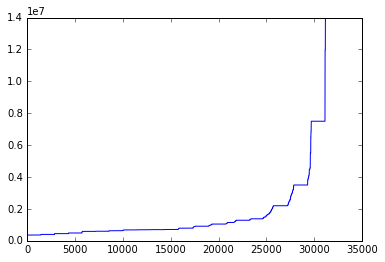

In [218]:
plt.plot(sorted(data.iloc[:,2]))
plt.show()

### Análise --POR QUARTOS--

In [344]:
quartos_stats = data.groupby('quartos')[['preco','area','suites','vagas', 'preco_m2']].describe()

quartos_stats


preco          area        suites         vagas  \
quartos                                                                 
1       count  1.284000e+04  12840.000000  12840.000000  12840.000000   
        mean   6.928961e+05  51.677259     0.332399      0.115498       
        std    2.442540e+05  9.605679      0.471091      0.319635       
        min    3.600000e+05  30.000000     0.000000      0.000000       
        25%    6.000000e+05  45.000000     0.000000      0.000000       
        50%    6.800000e+05  50.000000     0.000000      0.000000       
        75%    7.100000e+05  60.000000     1.000000      0.000000       
        max    1.500000e+06  100.000000    1.000000      1.000000       
2       count  1.078700e+04  10787.000000  10787.000000  10787.000000   
        mean   9.703367e+05  84.649300     0.433948      0.707704       
        std    6.242994e+05  26.848322     0.719113      0.704768       
        min    4.000000e+05  54.000000     0.000000      0.000000       
        25%    4.500000e+05  60.000000     0.000000      0.000000       
        50%    6.900000e+05  80.000000     0.000000      1.000000       
        75%    1.380000e+06  93.000000     1.000000      1.000000       
        max    4.600000e+06  206.000000    2.000000      3.000000       
3       count  6.828000e+03  6828.000000   6828.000000   6828.000000    
        mean   3.188132e+06  149.744435    1.171793      1.047891       
        std    2.511257e+06  48.876930     1.074185      1.152712       
        min    7.400000e+05  75.000000     0.000000      0.000000       
        25%    1.070000e+06  125.000000    0.000000      0.000000       
        50%    2.200000e+06  140.000000    1.000000      1.000000       
        75%    3.500000e+06  165.000000    1.000000      2.000000       
        max    1.400000e+07  430.000000    3.000000      3.000000       
4       count  7.070000e+02  707.000000    707.000000    707.000000     
        mean   3.696808e+06  208.978784    1.400283      1.900990       
        std    2.492360e+06  60.759041     1.024985      0.922699       
        min    1.200000e+06  110.000000    0.000000      0.000000       
        25%    1.900000e+06  170.000000    1.000000      1.000000       
        50%    2.900000e+06  200.000000    1.000000      2.000000       
        75%    4.490000e+06  240.000000    2.000000      3.000000       
        max    1.400000e+07  400.000000    4.000000      4.000000       
5       count  2.800000e+01  28.000000     28.000000     28.000000      
        mean   5.300000e+06  345.142857    2.857143      2.392857       
        std    1.422049e+06  16.251984     2.031498      1.523624       
        min    4.000000e+06  328.000000    1.000000      1.000000       
        25%    4.000000e+06  328.000000    1.000000      1.000000       
        50%    4.000000e+06  360.000000    1.000000      1.000000       
        75%    6.800000e+06  360.000000    5.000000      4.000000       
        max    6.800000e+06  360.000000    5.000000      4.000000       

                   preco_m2  
quartos                      
1       count  12840.000000  
        mean   13218.648481  
        std    2970.541524   
        min    7307.692308   
        25%    10888.888889  
        50%    12950.819672  
        75%    14166.666667  
        max    18970.588235  
2       count  10787.000000  
        mean   10603.656156  
        std    3613.043220   
        min    6666.666667   
        25%    7500.000000   
        50%    8625.000000   
        75%    13142.857143  
        max    40000.000000  
3       count  6828.000000   
        mean   19005.090911  
        std    9447.699593   
        min    7400.000000   
        25%    9208.471599   
        50%    17322.834646  
        75%    21875.000000  
        max    42857.142857  
4       count  707.000000    
        mean   17702.070120  
        std    9222.604923   
        min    5642.633229   
        25%    9882.347059   
        50%    16818.1818

### Printa, para número de quarto oferecidos, o valor do preço do imóvel/quantidade de anúncios com esse preço 
#### Preços ordenados do menor para o maior

In [297]:
print_full(data.groupby('quartos').preco.value_counts().sort_index())

quartos  preco   
1        360000      1400
         365000      14  
         377000      16  
         400000      17  
         430000      10  
         440000      17  
         450000      21  
         475000      18  
         490000      1400
         525000      15  
         528000      13  
         600000      1400
         630000      1400
         635000      15  
         650000      26  
         680000      1400
         685000      21  
         700000      1400
         710000      1400
         790000      1400
         795000      17  
         1290000     1400
         1500000     20  
2        400000      1400
         450000      1400
         575000      10  
         590000      1400
         649000      19  
         650000      38  
         660000      13  
         680000      29  
         690000      1427
         695000      18  
         700000      12  
         720000      24  
         730000      11  
         750000      20  
         760000     

### Análise de Preço/Número de ofertas para aquele preço --POR BAIRRO--

In [345]:
#Crio uma nova dataframe chamada bairros_stats onde coloco meu describe por bairro


bairros_stats = data.groupby('bairro')[['preco','area','suites','vagas','quartos', 'preco_m2']].describe()


bairros_stats  
#display(HTML(bairros_stats.to_html()))  #option used to display entire dataframe (not truncated)




#Ex de pesquisa na dataframe: 
#bairros_stats.loc['Botafogo']

preco          area        suites         vagas  \
bairro                                                                       
Botafogo     count  5.052000e+03  5052.000000   5052.000000   5052.000000    
             mean   9.215439e+05  77.168250     0.431314      0.745249       
             std    5.276575e+05  27.978620     0.572443      0.535631       
             min    4.900000e+05  45.000000     0.000000      0.000000       
             25%    4.900000e+05  45.000000     0.000000      0.000000       
             50%    6.900000e+05  80.000000     0.000000      1.000000       
             75%    1.380000e+06  93.000000     1.000000      1.000000       
             max    6.800000e+06  328.000000    5.000000      4.000000       
Catete       count  9.400000e+01  94.000000     94.000000     94.000000      
             mean   9.107553e+05  75.180851     0.691489      0.893617       
             std    2.395117e+05  16.612576     0.464355      0.309980       
             min    4.300000e+05  42.000000     0.000000      0.000000       
             25%    6.490000e+05  56.000000     0.000000      1.000000       
             50%    9.980000e+05  85.000000     1.000000      1.000000       
             75%    1.080000e+06  87.000000     1.000000      1.000000       
             max    1.150000e+06  87.000000     1.000000      1.000000       
Copacabana   count  1.220200e+04  12202.000000  12202.000000  12202.000000   
             mean   7.859319e+05  68.523275     0.275693      0.182347       
             std    3.593783e+05  37.710387     0.459718      0.409028       
             min    3.600000e+05  30.000000     0.000000      0.000000       
             25%    6.800000e+05  48.000000     0.000000      0.000000       
             50%    7.100000e+05  54.000000     0.000000      0.000000       
             75%    9.150000e+05  84.000000     1.000000      0.000000       
             max    4.490000e+06  350.000000    2.000000      2.000000       
Flamengo     count  4.430000e+02  443.000000    443.000000    443.000000     
             mean   1.687111e+06  159.006772    0.891648      0.916479       
             std    1.007555e+06  95.455599     0.765192      0.711746       
             min    5.280000e+05  45.000000     0.000000      0.000000       
             25%    9.500000e+05  87.000000     0.000000      0.000000       
             50%    1.600000e+06  136.000000    1.000000      1.000000       
...                          ...        ...          ...           ...       
Leblon       std    1.297904e+06  34.195577     0.485524      0.655859       
             min    8.500000e+05  67.000000     0.000000      0.000000       
             25%    1.290000e+06  68.000000     1.000000      0.000000       
             50%    1.290000e+06  68.000000     1.000000      0.000000       
             75%    1.460000e+06  80.000000     1.000000      1.000000       
             max    1.190000e+07  304.000000    4.000000      3.000000       
Leme         count  1.450000e+03  1450.000000   1450.000000   1450.000000    
             mean   6.546414e+05  61.283448     0.026897      0.026897       
             std    1.444025e+05  8.563589      0.161837      0.161837       
             min    6.300000e+05  60.000000     0.000000      0.000000       
             25%    6.300000e+05  60.000000     0.000000      0.000000       
             50%    6.300000e+05  60.000000     0.000000      0.000000       
             75%    6.300000e+05  60.000000     0.000000      0.000000       
             max    1.830000e+06  137.000000    1.000000      1.000000       
Santa Teresa count  2.800000e+03  2800.000000   2800.000000   2800.000000    
             mean   4.250000e+05  60.000000     0.000000      0.000000       
             std    2.500447e+04  0.000000      0.000000      0.000000       
             min    4.000000e+05  60.000000     0.000000      0.000000       
             25%    4.000000e+05  60.000000     0

In [346]:
#funçao pra printar todo o value counts (sem truncar)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
    
print_full(data.groupby('bairro').preco.value_counts())

bairro           preco   
Botafogo         690000      1409
                 490000      1400
                 1380000     1206
                 1150000     617 
                 650000      31  
                 800000      28  
                 970000      27  
                 1000000     26  
                 685000      21  
                 1850000     21  
                 750000      20  
                 1450000     18  
                 1300000     17  
                 1600000     17  
                 1250000     16  
                 1400000     16  
                 1655000     15  
                 3150000     15  
                 1080000     14  
                 1190000     14  
                 1360000     14  
                 660000      13  
                 4490000     13  
                 6800000     13  
                 2700000     12  
                 730000      11  
                 900000      11  
                 760000      10  
                 95000

### Análise de Preço/Número de ofertas para cada tipo de anúncio --POR No DE SUÍTES--

In [347]:
suites_stats = data.groupby('suites')[['preco','area','vagas','quartos', 'preco_m2']].describe()


suites_stats

preco          area         vagas       quartos  \
suites                                                                 
0      count  1.821500e+04  18215.000000  18215.000000  18215.000000   
       mean   6.752921e+05  67.030140     0.201592      1.649190       
       std    3.323017e+05  26.490063     0.411069      0.692329       
       min    3.600000e+05  30.000000     0.000000      1.000000       
       25%    4.900000e+05  50.000000     0.000000      1.000000       
       50%    6.300000e+05  60.000000     0.000000      2.000000       
       75%    7.000000e+05  80.000000     0.000000      2.000000       
       max    4.490000e+06  310.000000    2.000000      4.000000       
1      count  9.591000e+03  9591.000000   9591.000000   9591.000000    
       mean   1.646294e+06  95.332603     0.617454      1.965697       
       std    1.225652e+06  49.474002     0.635206      0.966796       
       min    3.770000e+05  30.000000     0.000000      1.000000       
       25%    7.900000e+05  61.000000     0.000000      1.000000       
       50%    1.290000e+06  78.000000     1.000000      2.000000       
       75%    1.725000e+06  120.000000    1.000000      3.000000       
       max    1.400000e+07  400.000000    3.000000      5.000000       
2      count  1.793000e+03  1793.000000   1793.000000   1793.000000    
       mean   2.380747e+06  150.446180    1.934189      2.278305       
       std    7.306204e+05  31.207820     0.439558      0.625056       
       min    9.000000e+05  58.000000     0.000000      2.000000       
       25%    2.200000e+06  142.000000    2.000000      2.000000       
       50%    2.200000e+06  142.000000    2.000000      2.000000       
       75%    2.200000e+06  142.000000    2.000000      2.000000       
       max    6.900000e+06  350.000000    3.000000      4.000000       
3      count  1.534000e+03  1534.000000   1534.000000   1534.000000    
       mean   7.246603e+06  219.226206    2.886571      3.029335       
       std    1.309721e+06  28.405007     0.459915      0.168799       
       min    1.800000e+06  121.000000    0.000000      3.000000       
       25%    7.500000e+06  220.000000    3.000000      3.000000       
       50%    7.500000e+06  220.000000    3.000000      3.000000       
       75%    7.500000e+06  220.000000    3.000000      3.000000       
       max    1.400000e+07  430.000000    3.000000      4.000000       
4      count  4.400000e+01  44.000000     44.000000     44.000000      
       mean   7.522727e+06  248.159091    3.204545      4.000000       
       std    3.480769e+06  54.221742     0.794737      0.000000       
       min    2.900000e+06  159.000000    2.000000      4.000000       
       25%    6.500000e+06  251.000000    3.000000      4.000000       
       50%    6.500000e+06  251.000000    3.000000      4.000000       
       75%    1.190000e+07  304.000000    4.000000      4.000000       
       max    1.190000e+07  304.000000    4.000000      4.000000       
5      count  1.300000e+01  13.000000     13.000000     13.000000      
       mean   6.800000e+06  328.000000    4.000000      5.000000       
       std    0.000000e+00  0.000000      0.000000      0.000000       
       min    6.800000e+06  328.000000    4.000000      5.000000       
       25%    6.800000e+06  328.000000    4.000000      5.000000       
       50%    6.800000e+06  328.000000    4.000000      5.000000       
       75%    6.800000e+06  328.000000    4.000000      5.000000       
       max    6.800000e+06  328.000000    4.000000      5.000000       

                  preco_m2  
suites                      
0      count  1.821500e+04  
       mean   1.022088e+04  
       std    2.479760e+03  
       min    6.666667e+03  
       25%    8.428571e+03  
       50%    1.050000e+04  
       75%    1.200000e+04  
       max    4.000000e+04  
1      count  9.591000e+03  
       mean   1.667102e+04  
       std    4.198907e+03  
       min    6.590909e+03  
       25%    

In [312]:
print_full(data.groupby('suites').preco.value_counts())

suites  preco   
0       1050000     1440
        680000      1429
        690000      1427
        450000      1421
        400000      1417
        700000      1412
        360000      1400
        490000      1400
        590000      1400
        600000      1400
        630000      1400
        915000      1400
        650000      64  
        1500000     51  
        890000      44  
        850000      42  
        1200000     42  
        980000      31  
        1100000     31  
        3800000     31  
        800000      28  
        1400000     27  
        720000      24  
        900000      24  
        1150000     24  
        4490000     23  
        1199999     22  
        1780000     22  
        2150000     22  
        685000      21  
        1149000     21  
        750000      20  
        999000      20  
        1075000     20  
        1679999     20  
        649000      19  
        1090000     19  
        1250002     19  
        1280000     19  
        

### Análise de Preço/Número de ofertas para cada tipo de anúncio --POR No DE VAGAS--

In [348]:
vagas_stats = data.groupby('vagas')[['preco','area','suites','quartos', 'preco_m2']].describe()
vagas_stats

preco          area        suites       quartos  \
vagas                                                                 
0     count  1.903500e+04  19035.000000  19035.000000  19035.000000   
      mean   9.077925e+05  69.320830     0.234568      1.561860       
      std    7.792121e+05  34.562536     0.430871      0.752702       
      min    3.600000e+05  30.000000     0.000000      1.000000       
      25%    4.900000e+05  48.000000     0.000000      1.000000       
      50%    6.800000e+05  60.000000     0.000000      1.000000       
      75%    9.150000e+05  70.000000     0.000000      2.000000       
      max    3.500000e+06  319.000000    3.000000      4.000000       
1     count  8.321000e+03  8321.000000   8321.000000   8321.000000    
      mean   1.099995e+06  89.892200     0.608461      2.124024       
      std    6.222604e+05  38.678620     0.560773      0.727880       
      min    5.250000e+05  30.000000     0.000000      1.000000       
      25%    6.900000e+05  70.000000     0.000000      2.000000       
      50%    7.900000e+05  80.000000     1.000000      2.000000       
      75%    1.380000e+06  94.000000     1.000000      3.000000       
      max    4.500000e+06  430.000000    3.000000      5.000000       
2     count  2.172000e+03  2172.000000   2172.000000   2172.000000    
      mean   2.478251e+06  147.445672    1.709945      2.428177       
      std    1.456233e+06  39.040428     0.581167      0.690728       
      min    8.650000e+05  75.000000     0.000000      2.000000       
      25%    2.200000e+06  142.000000    1.000000      2.000000       
      50%    2.200000e+06  142.000000    2.000000      2.000000       
      75%    2.200000e+06  142.000000    2.000000      3.000000       
      max    1.400000e+07  400.000000    4.000000      4.000000       
3     count  1.630000e+03  1630.000000   1630.000000   1630.000000    
      mean   7.280288e+06  220.684049    2.844785      3.096319       
      std    1.203529e+06  15.348825     0.505179      0.339608       
      min    3.300000e+06  170.000000    1.000000      2.000000       
      25%    7.500000e+06  220.000000    3.000000      3.000000       
      50%    7.500000e+06  220.000000    3.000000      3.000000       
      75%    7.500000e+06  220.000000    3.000000      3.000000       
      max    1.400000e+07  340.000000    4.000000      4.000000       
4     count  3.200000e+01  32.000000     32.000000     32.000000      
      mean   6.621875e+06  282.281250    4.406250      4.406250       
      std    1.496973e+05  38.422301     0.498991      0.498991       
      min    6.500000e+06  251.000000    4.000000      4.000000       
      25%    6.500000e+06  251.000000    4.000000      4.000000       
      50%    6.500000e+06  251.000000    4.000000      4.000000       
      75%    6.800000e+06  328.000000    5.000000      5.000000       
      max    6.800000e+06  328.000000    5.000000      5.000000       

                 preco_m2  
vagas                      
0     count  19035.000000  
      mean   12404.748782  
      std    4378.285226   
      min    5642.633229   
      25%    9473.684211   
      50%    10892.857143  
      75%    14166.666667  
      max    28000.000000  
1     count  8321.000000   
      mean   12072.254989  
      std    3684.752322   
      min    5685.714286   
      25%    8625.000000   
      50%    12950.819672  
      75%    14743.589744  
      max    40000.000000  
2     count  2172.000000   
      mean   16501.526626  
      std    4824.465447   
      min    7100.000000   
      25%    15492.957746  
      50%    15492.957746  
      75%    15492.957746  
      max    42857.142857  
3     count  1630.000000   
      mean   32912.209755  
      std    4265.078902   
      min    17083.333333  
      25%    34090.909091  
      50%    34090.909091  
      75%    34090.909091  
      max    41176.470588  
4     count  32.000000     
      mean   23798.252113  
      std    2577.141896   
 

In [316]:
print_full(data.groupby('suites').preco.value_counts())

suites  preco   
0       1050000     1440
        680000      1429
        690000      1427
        450000      1421
        400000      1417
        700000      1412
        360000      1400
        490000      1400
        590000      1400
        600000      1400
        630000      1400
        915000      1400
        650000      64  
        1500000     51  
        890000      44  
        850000      42  
        1200000     42  
        980000      31  
        1100000     31  
        3800000     31  
        800000      28  
        1400000     27  
        720000      24  
        900000      24  
        1150000     24  
        4490000     23  
        1199999     22  
        1780000     22  
        2150000     22  
        685000      21  
        1149000     21  
        750000      20  
        999000      20  
        1075000     20  
        1679999     20  
        649000      19  
        1090000     19  
        1250002     19  
        1280000     19  
        

In [357]:

bairros_stats = data.groupby(['bairro','quartos'])[['preco','area','suites','vagas', 'preco_m2']].describe()

bairros_stats
#bairros_quartos = bairros_stats.groupby('quartos')


preco         area       suites  \
bairro       quartos                                                 
Botafogo     1       count  1.433000e+03  1433.000000  1433.000000   
                     mean   4.941975e+05  45.385206    0.000000      
                     std    2.746858e+04  2.594494     0.000000      
                     min    4.900000e+05  45.000000    0.000000      
                     25%    4.900000e+05  45.000000    0.000000      
                     50%    4.900000e+05  45.000000    0.000000      
                     75%    4.900000e+05  45.000000    0.000000      
                     max    6.850000e+05  65.000000    0.000000      
             2       count  2.814000e+03  2814.000000  2814.000000   
                     mean   1.002431e+06  88.244136    0.464108      
                     std    3.368575e+05  10.514785    0.498799      
                     min    6.500000e+05  54.000000    0.000000      
                     25%    6.900000e+05  80.000000    0.000000      
                     50%    6.900000e+05  80.000000    0.000000      
                     75%    1.380000e+06  93.000000    1.000000      
                     max    1.380000e+06  105.000000   1.000000      
             3       count  7.260000e+02  726.000000   726.000000    
                     mean   1.193588e+06  83.119835    0.983471      
                     std    2.259067e+05  12.593078    0.392695      
                     min    8.000000e+05  78.000000    0.000000      
                     25%    1.150000e+06  78.000000    1.000000      
                     50%    1.150000e+06  78.000000    1.000000      
                     75%    1.150000e+06  78.000000    1.000000      
                     max    2.700000e+06  140.000000   3.000000      
             4       count  6.600000e+01  66.000000    66.000000     
                     mean   2.601061e+06  180.136364   1.424242      
                     std    1.107924e+06  52.937666    0.498015      
                     min    1.600000e+06  110.000000   1.000000      
                     25%    1.662500e+06  110.000000   1.000000      
                     50%    1.850000e+06  176.000000   1.000000      
...                                  ...         ...        ...      
Leme         3       std    0.000000e+00  0.000000     0.000000      
                     min    1.830000e+06  137.000000   1.000000      
                     25%    1.830000e+06  137.000000   1.000000      
                     50%    1.830000e+06  137.000000   1.000000      
                     75%    1.830000e+06  137.000000   1.000000      
                     max    1.830000e+06  137.000000   1.000000      
Santa Teresa 2       count  2.800000e+03  2800.000000  2800.000000   
                     mean   4.250000e+05  60.000000    0.000000      
                     std    2.500447e+04  0.000000     0.000000      
                     min    4.000000e+05  60.000000    0.000000      
                     25%    4.000000e+05  60.000000    0.000000      
                     50%    4.250000e+05  60.000000    0.000000      
                     75%    4.500000e+05  60.000000    0.000000      
                     max    4.500000e+05  60.000000    0.000000      
Urca         2       count  3.400000e+01  34.000000    34.000000     
                     mean   1.149382e+06  84.205882    0.000000      
                     std    4.932702e+02  11.345215    0.000000      
                     min    1.149000e+06  70.000000    0.000000      
                     25%    1.149000e+06  70.000000    0.000000      
                     50%    1.149000e+06  93.000000    0.000000      
                     75%    1.150000e+06  93.000000    0.000000      
                     max    1.150000e+06  93.000000    0.000000      
             3       count  1.700000e+01  17.000000    17.000000     
                     mean   3.000000e+06  165.000000   0.000000      
                     std    0.000000e+00  0.0

In [360]:
subdata = data.iloc[:,2:].copy()
subdata = subdata.drop("endereco",1)
subdata = subdata.drop("descricao",1)

df = subdata
counts = df.groupby(['preco']).agg(len)
counts

,bairro,quartos,area,suites,vagas,preco_m2
preco,,,,,,
360000,1400,1400,1400,1400,1400,1400.0
365000,14,14,14,14,14,14.0
377000,16,16,16,16,16,16.0
400000,1417,1417,1417,1417,1417,1417.0
430000,10,10,10,10,10,10.0
440000,17,17,17,17,17,17.0
450000,1421,1421,1421,1421,1421,1421.0
475000,18,18,18,18,18,18.0
490000,1400,1400,1400,1400,1400,1400.0


In [ ]:
data.groupby('Bairro')[['preco','area','suites','quartos']].describe()

In [358]:
bairro_preco = [Bar(x=data.bairro,
            y=data.preco)]

py.iplot(bairro_preco)

### Examining the categorical values

In [229]:
for cat in ['bairro','endereco']:
    print("Unique values for category '{0}': \b {1} ".format(cat, data[cat].unique()))
    print()

print("\nNúmero de bairros diferentes: ", len(data["bairro"].unique()))
print("\nNúmero de enderecos (ruas) diferentes: ", len(data["endereco"].unique()))

Unique values for category 'bairro':  ['Botafogo' 'Copacabana' 'Leblon' 'Gávea' 'Jardim Botânico' 'Glória'
 'Lagoa' 'Santa Teresa' 'Leme' 'Ipanema' 'Laranjeiras' 'Humaitá' 'Urca'
 'Flamengo' 'Catete'] 

Unique values for category 'endereco':  ['Rua Sorocaba' 'Rua Pinheiro Guimarães'
 'Rua Marechal Mascarenhas de Morais' 'Rua General Venâncio Flores'
 'Rua Sambaíba' 'Rua Siqueira Campos' 'Marques de São Vicente'
 'Rua Abreu Fialho' 'Avenida Ataulfo de Paiva'
 'Rua Ministro Viveiros de Castro' 'Rua Voluntários da Pátria'
 'Rua Benjamim Constant' 'R Santa Clara' 'Avenida Epitácio Pessoa'
 'Rua Décio Vilares' 'Rua Santa Clara' 'Avenida Princesa Isabel'
 'Rua Pinto Martins' 'Rua Prefeito João Felipe'
 'Avenida Nossa Senhora de Copacabana' 'Rua Gustavo Sampaio'
 'Rua Constante Ramos' 'Rua Redentor' 'Rua Assunção'
 'Rua Baronesa de Poconé' 'Rua Henrique de Novais' 'Avenida Delfim Moreira'
 'Rua da Matriz' 'Rua Alberto de Campos' 'Rua Almirante Saddock de Sá'
 'Avenida Atlântica' 'Rua Presid